<a href="https://colab.research.google.com/github/wlgns222/Baekjoon/blob/main/ai-study/deep-learning-from-scratch-vol1/Ch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Ch5. 오차역전파법**

## 5.1 계산 그래프

## 5.2 연쇄법칙

## 5.3 역전파

## 5.4 단순한 계층 구현하기

### 5.4.1 곱셈 계층

In [ ]:
class MulLayer:
  def __init__(self):
    self.x = None
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x * y
    return out

  def backward(self, dout):
    dx = dout * self.y
    dy = dout * self.x
    return dx, dy

### 5.4.2 덧셈 계층

In [ ]:
class AddLayer:
  def __init__(self) :
    pass
  def forward(self, x, y):
    out = x + y
    return out
  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1

### 5.4 시스템 조립

In [ ]:
# 1. 환경 설정 (데이터)
apple = 100; apple_num = 2
orange = 150; orange_num = 3
tax = 1.1

# 2. 계층(Layer) 생성
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 3. 순전파 (Forward)
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# 4. 역전파 (Backward)
dprice = 1 # 시작 미분값
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print(f"최종 가격: {int(price)}")
print(f"사과 개수에 대한 미분: {dapple_num}")
print(f"귤 가격에 대한 미분: {dorange}")
print(f"소비세에 대한 미분: {dtax}")

## 5.5 활성화 함수 계층 구현하기

### 5.5.1 ReLU 계층

**ReLU의 순전파 (Forward)**

ReLU는 입력 x 가 0보다 크면 그대로 내보내고, 0 이하면 0을 내보낸다.

$$y = \begin{cases} x & (x > 0) \\ 0 & (x \le 0) \end{cases}$$


**ReLU의 역전파 (Backward)**
- 순전파 때 x > 0 이었다면 : 미분값이 1 이다. 즉 뒤에서 온 미분값을 그대로 전달한다.
- 순전파 때 x < 0 이었다면 : 미분값이 0 이다. 즉, 뒤에서 온 미분값이 무엇이든 0 을 전달한다.

$$\frac{\partial y}{\partial x} = \begin{cases} 1 & (x > 0) \\ 0 & (x \le 0) \end{cases}$$

In [61]:
import numpy as np

class ReLU:
  def __init__(self) :
    self.mask = None

  def forward(self, x):
    self.mask = (x<=0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx


인스턴스 변수 **mask**
- True/False 로 구성된 넘파이 배열
- 어떤 원소가 0 이하였는지 기억하는 변수

In [60]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)

[[ 1.  -0.5]
 [-2.   3. ]]


In [62]:
mask = (x<=0)
print(mask)

[[False  True]
 [ True False]]


**ReLU 기울기 차단 이유**
- 기울기 소실 방지 : 0보다 큰 영역에서 기울기가 항상 1이기 때문에, 층이 깊어져도 신호가 약해지지 않고 끝까지 전달된다.
- 신경망의 전원 스위치 : x<=0 일때 기울기를 0으로 만드는 것은 해당 뉴런이 현재 학습에 기여하지 않도록 전원을 끄는것과 같다. 이는 모델이 불필요한 정보에 반응하지 않도록 하는 효과를 준다.

### 5.5.2 Sigmoid 계층


$y = \frac{1}{1 + \exp(-x)}$

In [55]:
class Sigmoid :
  def __init__(self):
    self.out = None
  def forward(self,x):
    out = 1 / (1+np.exp(-x))
    return out
  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx

## 5.6 Affine/Softmax 계층 구현하기

### 5.6.2 배치용 Affine 계층

In [56]:
class Affine :
  def __init__ (self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None
  def forward (self, x):
    self.x = x
    out = np.dot(x, self.W) + b
    return out
  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dout(self.x.T, dout)
    self.db = np.sum(dout, axis = 0)
    return dx

### 5.6.3 Softmax-with-Loss 계층

In [57]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [58]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None
  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y-self.t) / batch_size
    return dx

## 5.7 오차역전파법 구현하기

### 5.7.1 신경망 학습의 전체 그림

**전제**

신경망에는 적응 가능한 가중치와 편향이 있으며, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라고 한다. 신경망 학습은 다음 4단계로 수행한다.

**1단계 - 미니배치**

훈련 데이터 중 일부를 무작위로 가지고 온다.

**2단계 - 기울기산출**

미니배치 손실함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다.

**3단계 - 매개변수 갱신**

가중치 매개변수의 기울기 방향으로 아주 조금 갱신한다.

**4단계 - 반복**

1~3 단계를 반복한다.

### 5.7.2 오차역전파법을 적용한 신경망 구현

In [50]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
# 밑바닥부터 시작하는 딥러닝 예제 저장소.
if not os.path.exists('deep-learning-from-scratch'):
    !git clone https://github.com/WegraLee/deep-learning-from-scratch.git

sys.path.append('deep-learning-from-scratch')
from dataset.mnist import load_mnist

In [51]:
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 1. 가중치 초기화 (Neural Network의 초기 파라미터 분산 설정)
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 2. 계층 생성 (OrderedDict를 사용하여 순서가 있는 레이어 층을 구성)
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
      y = self.predict(x)
      y = np.argmax(y, axis=1)
      if t.ndim != 1 : t = np.argmax(t, axis=1)

      accuracy = np.sum(y == t) / float(x.shape[0])
      return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # [Step 1] 순전파 (Forward Propagation)
        self.loss(x, t)

        # [Step 2] 역전파 (Backward Propagation)
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse() # 레이어를 거꾸로 뒤집어 미분을 전파
        for layer in layers:
            dout = layer.backward(dout)

        # [Step 3] 결과 저장 (각 Affine 계층에 저장된 미분값들을 수집)
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

### 5.7.3 오차역전파법으로 구한 기울기 검증

In [52]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_backprop = network.gradient(x_batch, t_batch)
grad_numerical = network.numerical_gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(f"{key} 차이(diff): {diff}")

W1 차이(diff): 4.823389501981526e-10
b1 차이(diff): 2.936721088192277e-09
W2 차이(diff): 7.1782058004618415e-09
b2 차이(diff): 1.4002320169875792e-07


### 5.7.4 오차역전파법을 사용한 학습 구현하기

0.9950333333333333 0.9752
0.99515 0.9753
0.9955 0.9751
0.9954833333333334 0.9743
0.9961 0.9761
0.9956666666666667 0.9766
0.9962 0.9764
0.9964666666666666 0.9757
0.9962666666666666 0.9753
0.9967 0.9744
0.9968833333333333 0.9753
0.99725 0.9753
0.9969833333333333 0.9745
0.9971166666666667 0.977
0.9968833333333333 0.9749
0.9975333333333334 0.9754
0.99765 0.9756


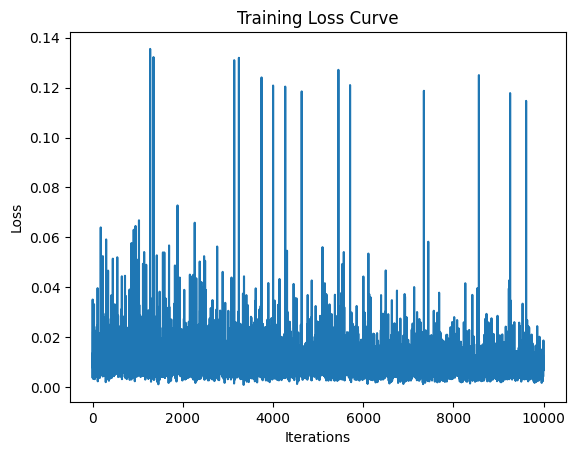

In [65]:
# 하이퍼파라미터 설정

iters_num = 10000  # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 오차역전파법으로 기울기 구하기
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신 (SGD 방식)
    for key in ('W1', 'b1', 'W2', 'b2'):
      network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)


    if i %  iter_per_epoch == 0:
      train_acc = network.accuracy(x_train, t_train)
      test_acc = network.accuracy(x_test, t_test)
      train_acc_list.append(train_acc)
      test_acc_list.append(test_acc)
      print(train_acc, test_acc)

plt.plot(train_loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()